## String generation

In [38]:
import random
import numpy as np
import matplotlib.pyplot as plt
from difflib import SequenceMatcher

In [39]:
alphabet = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ,.! '
target = 'Hello World'

In [40]:
class Individual:
    def __init__(self, string, fitness = 0):
        self.string = string
        self.fitness = fitness
        
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

def spawn_population(length = 26, size = 100):
    pop = []
    for i in range(size):
        string = ''.join(random.choices(alphabet, k = length))
        individual = Individual(string)
        pop.append(individual)
    return pop

def recombine(parent_1, parent_2):
    parent_1 = parent_1.string
    parent_2 = parent_2.string
    child_1 = []
    child_2 = []
    cross_point = random.randint(0, len(parent_1))
    child_1.extend(parent_1[0:cross_point])
    child_1.extend(parent_2[cross_point:])
    child_2.extend(parent_2[0:cross_point])
    child_2.extend(parent_2[cross_point:])
    child_1 = Individual(''.join(child_1))
    child_2 = Individual(''.join(child_2))
    return child_1, child_2

def mutate(x, rate = 0.01):
    new_x = []
    for char in x.string:
        if random.random() < rate:
            new_x.extend(random.choices(alphabet, k = 1))
        else:
            new_x.append(char)
    new_x = Individual(''.join(new_x))
    return new_x

def evaluate_population(pop, target):
    avg_fit = 0
    for i in range(len(pop)):
        fit = similar(pop[i].string, target)
        pop[i].fitness = fit
        avg_fit += fit
    avg_fit /= len(pop)
    return pop, avg_fit

def next_generation(pop, size = 100, length = 26, mut_rate = 0.01):
    new_pop = []
    while len(new_pop) < size:
        parents = random.choices(pop, k = 2, weights = [x.fitness for x in pop])
        offspring = recombine(parents[0], parents[1])
        child_1 = mutate(offspring[0], rate = mut_rate)
        child_2 = mutate(offspring[1], rate = mut_rate)
        offspring = [child_1, child_2]
        new_pop.extend(offspring)
    return new_pop    

In [41]:
num_generations = 200
population_size = 900
str_len = len(target)
mutation_rate = 1e-3

pop_fit = []
pop = spawn_population(size = population_size, length = str_len)

for gen in range(num_generations):
    pop, avg_fit = evaluate_population(pop, target)
    pop_fit.append(avg_fit)
    new_pop = next_generation(pop, size = population_size, length = str_len, mut_rate = mutation_rate)
    pop = new_pop
    if gen % 10 == 0:
        print(f'Generation: {gen:03d} | Avg. fit: {np.mean(pop_fit[-10:]):.4f}')

Generation: 000 | Avg. fit: 0.1118
Generation: 010 | Avg. fit: 0.2456
Generation: 020 | Avg. fit: 0.4298
Generation: 030 | Avg. fit: 0.5673
Generation: 040 | Avg. fit: 0.6621
Generation: 050 | Avg. fit: 0.7061
Generation: 060 | Avg. fit: 0.7489
Generation: 070 | Avg. fit: 0.7852
Generation: 080 | Avg. fit: 0.7943
Generation: 090 | Avg. fit: 0.7966
Generation: 100 | Avg. fit: 0.7997
Generation: 110 | Avg. fit: 0.8030
Generation: 120 | Avg. fit: 0.8019
Generation: 130 | Avg. fit: 0.8015
Generation: 140 | Avg. fit: 0.8044
Generation: 150 | Avg. fit: 0.8061
Generation: 160 | Avg. fit: 0.8055
Generation: 170 | Avg. fit: 0.8090
Generation: 180 | Avg. fit: 0.8076
Generation: 190 | Avg. fit: 0.8061


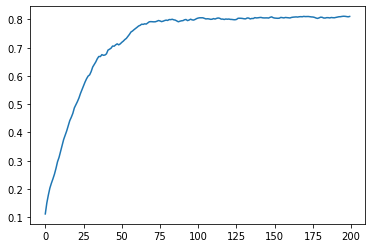

In [43]:
plt.plot(range(num_generations), pop_fit);

In [44]:
pop.sort(key = lambda x: x.fitness, reverse = True)

pop[0].string

'Helloo Wodl'

## Cartpole

In [78]:
import torch
import gym
import pandas as pd

In [71]:
def model(x, parameters):
    hidden_1, bias_1, hidden_2, bias_2, hidden_3, bias_3 = parameters
    y = torch.nn.functional.linear(x, hidden_1, bias_1)
    y = torch.relu(y)
    y = torch.nn.functional.linear(y, hidden_2, bias_2)
    y = torch.relu(y)
    y = torch.nn.functional.linear(y, hidden_3, bias_3)
    y = torch.log_softmax(y, dim = 0)
    return y

def unpack_parameters(params, layers = [(25, 4), (10, 25), (2, 10)]):
    unpacked_params = []
    e = 0
    for i, l in enumerate(layers):
        s, e = e, e + np.prod(l)
        weights = params[s:e].view(l)
        s, e = e, e + l[0]
        bias = params[s:e]
        unpacked_params.extend([weights, bias])
    return unpacked_params

def spawn_population(pop_size = 50, num_params = 407):
    pop = []
    for i in range(pop_size):
        vec = torch.randn(num_params) / 2.0
        fit = 0
        p = {'params': vec, 'fitness': fit}
        pop.append(p)
    return pop

def recombine(agent_1, agent_2):
    agent_1 = agent_1['params']
    agent_2 = agent_2['params']
    length = agent_1.shape[0]
    split_point = np.random.randint(length)
    child_1 = torch.zeros(length)
    child_2 = torch.zeros(length)
    child_1[0:split_point] = agent_1[0:split_point]
    child_1[split_point:] = agent_2[split_point:]
    child_2[0:split_point] = agent_2[0:split_point]
    child_2[split_point:] = agent_1[split_point:]
    child_1 = {'params': child_1, 'fitness': 0.0} 
    child_2 = {'params': child_2, 'fitness': 0.0}
    return child_1, child_2

def mutate(agent, rate = 0.01):
    new_params = agent['params']
    num_changes = int(rate * new_params.shape[0])
    idx = np.random.randint(0, new_params.shape[0], size = (num_changes,))
    new_params[idx] = torch.randn(num_changes) / 10.0
    agent['params'] = new_params
    return agent

def test_model(agent):
    finished = False
    state = torch.from_numpy(env.reset()).float()
    score = 0
    while not finished:
        params = unpack_parameters(agent['params'])
        probs = model(state, params)
        action = torch.distributions.Categorical(probs = probs).sample()
        state_new, _, finished, _ = env.step(action.item())
        state = torch.from_numpy(state_new).float()
        score += 1
    return score

def evaluate_population(pop):
    fit_total = 0 
    for agent in pop: 
        score = test_model(agent) 
        agent['fitness'] = score 
        fit_total += score
    avg_fit = fit_total / len(pop)
    return pop, avg_fit

def next_generation(pop, mut_rate = 0.001, tournament_size = 0.2):
    new_pop = []
    len_pop = len(pop)
    while len(new_pop) < len(pop): 
        rids = np.random.randint(0, len_pop, size = (int(tournament_size * len_pop)))
        batch = np.array([[i, x['fitness']] for (i, x) in enumerate(pop) if i in rids]) 
        scores = batch[batch[:, 1].argsort()] 
        i_best, i_secbest = int(scores[-1][0]), int(scores[-2][0]) 
        parent_1, parent_2 = pop[i_best], pop[i_secbest]
        offspring_ = recombine(parent_1, parent_2) 
        child_1 = mutate(offspring_[0], rate = mut_rate) 
        child_2 = mutate(offspring_[1], rate = mut_rate)
        offspring = [child_1, child_2]
        new_pop.extend(offspring)
    return new_pop

In [76]:
env = gym.make("CartPole-v0")

num_generations = 50
population_size = 500
mutation_rate = 0.01
pop_fit = []
pop = spawn_population(pop_size = population_size, num_params = 407)

for i in range(num_generations):
    pop, avg_fit = evaluate_population(pop)
    pop_fit.append(avg_fit)
    pop = next_generation(pop, mut_rate = mutation_rate, tournament_size = 0.2)
    if i % 5 == 0:
        print(f'Generation: {i:02d} | Avg. fit: {np.mean(pop_fit[-5:]):.2f}')

Generation: 00 | Avg. fit: 15.71
Generation: 05 | Avg. fit: 89.24
Generation: 10 | Avg. fit: 149.84
Generation: 15 | Avg. fit: 151.60
Generation: 20 | Avg. fit: 153.58
Generation: 25 | Avg. fit: 160.12
Generation: 30 | Avg. fit: 161.88
Generation: 35 | Avg. fit: 159.54
Generation: 40 | Avg. fit: 157.79
Generation: 45 | Avg. fit: 159.28


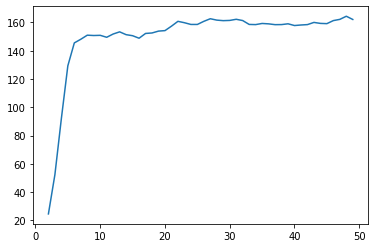

In [80]:
pop_fit = pd.Series(pop_fit).rolling(3).mean()

plt.plot(range(num_generations), pop_fit);